In [1]:
import argparse
import itertools
import os
import random
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from tqdm import tqdm

from dataset import bair_robot_pushing_dataset
from models.lstm import gaussian_lstm, lstm
from models.vgg_64 import vgg_decoder, vgg_encoder
from utils import init_weights, kl_criterion, plot_pred, plot_rec, finn_eval_seq, pred

torch.backends.cudnn.benchmark = True

Random Seed:  1
Namespace(lr=0.0005, beta1=0.9, batch_size=12, log_dir='./logs/fp/rnn_size=256-predictor-posterior-rnn_layers=2-1-n_past=2-n_future=10-lr=0.0005-g_dim=128-z_dim=64-last_frame_skip=False-beta=0.0001000', model_dir='', data_root='../processed_data', optimizer='adam', niter=300, epoch_size=600, tfr=1.0, tfr_start_decay_epoch=150, tfr_decay_step=0.01, tfr_lower_bound=0.0, kl_anneal_cyclical=True, kl_anneal_ratio=2, kl_anneal_cycle=4, seed=1, n_past=2, n_future=10, n_eval=30, rnn_size=256, posterior_rnn_layers=1, predictor_rnn_layers=2, z_dim=64, g_dim=128, beta=0.0001, num_workers=8, last_frame_skip=False, cuda=True)


  0%|▌                                                                                                                                                                    | 1/300 [06:01<30:00:48, 361.37s/it]Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 pri

 34%|█████████████████████████████████████████████████████▊                                                                                                          | 101/300 [14:10:49<24:16:15, 439.08s/it]Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 pri

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 201/300 [25:04:12<7:13:40, 262.84s/it]Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 pri

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [33:33:05<00:00, 304.09s/it]

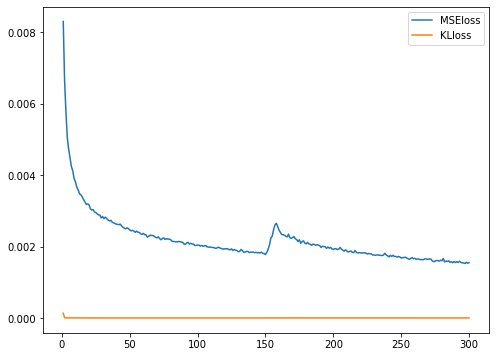

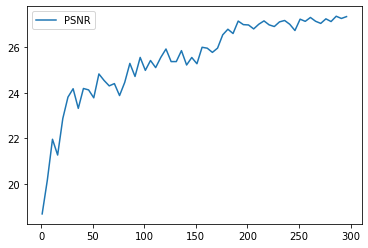

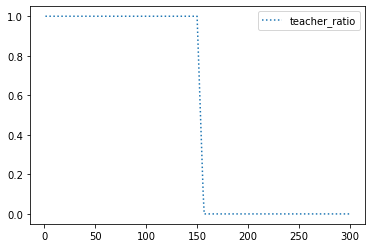

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [33:33:05<00:00, 402.62s/it]


In [2]:
def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--lr', default=0.0005, type=float, help='learning rate')
    parser.add_argument('--beta1', default=0.9, type=float, help='momentum term for adam')
    parser.add_argument('--batch_size', default=12, type=int, help='batch size')
    parser.add_argument('--log_dir', default='./logs/fp', help='base directory to save logs')
    parser.add_argument('--model_dir', default='', help='base directory to save logs')
    parser.add_argument('--data_root', default='../processed_data', help='root directory for data')
    parser.add_argument('--optimizer', default='adam', help='optimizer to train with')
    parser.add_argument('--niter', type=int, default=300, help='number of epochs to train for')
    parser.add_argument('--epoch_size', type=int, default=600, help='epoch size')
    parser.add_argument('--tfr', type=float, default=1.0, help='teacher forcing ratio (0 ~ 1)')
    parser.add_argument('--tfr_start_decay_epoch', type=int, default=150, help='The epoch that teacher forcing ratio become decreasing')
    parser.add_argument('--tfr_decay_step', type=float, default=0.01, help='The decay step size of teacher forcing ratio (0 ~ 1)')
    parser.add_argument('--tfr_lower_bound', type=float, default=0.0, help='The lower bound of teacher forcing ratio for scheduling teacher forcing ratio (0 ~ 1)')
    parser.add_argument('--kl_anneal_cyclical', default=True, action='store_true', help='use cyclical mode')
    parser.add_argument('--kl_anneal_ratio', type=float, default=2, help='The decay ratio of kl annealing')
    parser.add_argument('--kl_anneal_cycle', type=int, default=4, help='The number of cycle for kl annealing (if use cyclical mode)')
    parser.add_argument('--seed', default=1, type=int, help='manual seed')
    parser.add_argument('--n_past', type=int, default=2, help='number of frames to condition on')
    parser.add_argument('--n_future', type=int, default=10, help='number of frames to predict')
    parser.add_argument('--n_eval', type=int, default=30, help='number of frames to predict at eval time')
    parser.add_argument('--rnn_size', type=int, default=256, help='dimensionality of hidden layer')
    parser.add_argument('--posterior_rnn_layers', type=int, default=1, help='number of layers')
    parser.add_argument('--predictor_rnn_layers', type=int, default=2, help='number of layers')
    parser.add_argument('--z_dim', type=int, default=64, help='dimensionality of z_t')
    parser.add_argument('--g_dim', type=int, default=128, help='dimensionality of encoder output vector and decoder input vector')
    parser.add_argument('--beta', type=float, default=0.0001, help='weighting on KL to prior')
    parser.add_argument('--num_workers', type=int, default=8, help='number of data loading threads')
    parser.add_argument('--last_frame_skip', action='store_true', help='if true, skip connections go between frame t and frame t+t rather than last ground truth frame')
    parser.add_argument('--cuda', default=True, action='store_true')  

    args = parser.parse_args(args=[])
    return args

def train(x, cond, modules, optimizer, kl_anneal, args):
    modules['frame_predictor'].zero_grad()
    modules['posterior'].zero_grad()
    modules['encoder'].zero_grad()
    modules['decoder'].zero_grad()

    # initialize the hidden state.
    modules['frame_predictor'].hidden = modules['frame_predictor'].init_hidden()
    modules['posterior'].hidden = modules['posterior'].init_hidden()
    mse = 0
    kld = 0
    
    x_pred = x[0]
    for i in range(1, args.n_past + args.n_future):   
        use_teacher_forcing = True if random.random() < args.tfr else False
        h_target = modules['encoder'](x[i])[0]
        if use_teacher_forcing == True:
            if args.last_frame_skip or i < args.n_past:
                h, skip = modules['encoder'](x[i-1])
            else:
                h = modules['encoder'](x[i-1])[0]
        else:
            if args.last_frame_skip or i < args.n_past:
                h, skip = modules['encoder'](x_pred)
            else:
                h = modules['encoder'](x_pred)[0]
        
        z_t, mu, logvar = modules['posterior'](h_target)
        h_pred = modules['frame_predictor'](torch.cat([cond[i-1], h, z_t], 1))
        x_pred = modules['decoder']([h_pred, skip])
        mse += nn.MSELoss()(x_pred, x[i])
        kld += kl_criterion(mu, logvar, args)

    beta = kl_anneal.get_beta()
    loss = mse + kld * beta
    loss.backward()

    optimizer.step()

    return loss.detach().cpu().numpy() / (args.n_past + args.n_future), mse.detach().cpu().numpy() / (args.n_past + args.n_future), kld.detach().cpu().numpy() / (args.n_future + args.n_past)

class kl_annealing():
    def __init__(self, args):
        super().__init__()
        self.cyclical = args.kl_anneal_cyclical
        self.cycle = args.kl_anneal_cycle
        self.ratio = args.kl_anneal_ratio
        self.period = args.epoch_size // self.cycle
        self.step_size = 1 / (self.period*self.ratio)
        self.beta = 0
        self.iter = 0
    
    def update(self):
        self.beta += self.step_size
        if self.cyclical == True and self.iter%self.period == 0:
            self.beta = 0
        self.beta = min(1, self.beta)
        self.iter += 1
    
    def get_beta(self):
        beta = self.beta
        self.update()
        return beta


def main():
    args = parse_args()
    if args.cuda:
        assert torch.cuda.is_available(), 'CUDA is not available.'
        device = 'cuda:3'
    else:
        device = 'cpu'
    
    assert args.n_past + args.n_future <= 30 and args.n_eval <= 30
    assert 0 <= args.tfr and args.tfr <= 1
    assert 0 <= args.tfr_start_decay_epoch 
    assert 0 <= args.tfr_decay_step and args.tfr_decay_step <= 1

    if args.model_dir != '':
        # load model and continue training from checkpoint
        saved_model = torch.load('%s/model.pth' % args.model_dir)
        optimizer = args.optimizer
        model_dir = args.model_dir
        niter = args.niter
        args = saved_model['args']
        args.optimizer = optimizer
        args.model_dir = model_dir
        args.log_dir = '%s/continued' % args.log_dir
        start_epoch = saved_model['last_epoch']
    else:
        name = 'rnn_size=%d-predictor-posterior-rnn_layers=%d-%d-n_past=%d-n_future=%d-lr=%.4f-g_dim=%d-z_dim=%d-last_frame_skip=%s-beta=%.7f'\
            % (args.rnn_size, args.predictor_rnn_layers, args.posterior_rnn_layers, args.n_past, args.n_future, args.lr, args.g_dim, args.z_dim, args.last_frame_skip, args.beta)

        args.log_dir = '%s/%s' % (args.log_dir, name)
        niter = args.niter
        start_epoch = 0

    os.makedirs(args.log_dir, exist_ok=True)
    os.makedirs('%s/gen/' % args.log_dir, exist_ok=True)

    print("Random Seed: ", args.seed)
    random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed_all(args.seed)

    if os.path.exists('./{}/train_record.txt'.format(args.log_dir)):
        os.remove('./{}/train_record.txt'.format(args.log_dir))
    
    print(args)

    with open('./{}/train_record.txt'.format(args.log_dir), 'a') as train_record:
        train_record.write('args: {}\n'.format(args))

    # ------------ build the models  --------------

    if args.model_dir != '':
        frame_predictor = saved_model['frame_predictor']
        posterior = saved_model['posterior']
    else:
        frame_predictor = lstm(7+args.g_dim+args.z_dim, args.g_dim, args.rnn_size, args.predictor_rnn_layers, args.batch_size, device)
        posterior = gaussian_lstm(args.g_dim, args.z_dim, args.rnn_size, args.posterior_rnn_layers, args.batch_size, device)
        frame_predictor.apply(init_weights)
        posterior.apply(init_weights)
            
    if args.model_dir != '':
        decoder = saved_model['decoder']
        encoder = saved_model['encoder']
    else:
        encoder = vgg_encoder(args.g_dim)
        decoder = vgg_decoder(args.g_dim)
        encoder.apply(init_weights)
        decoder.apply(init_weights)
    
    # --------- transfer to device ------------------------------------
    frame_predictor.to(device)
    posterior.to(device)
    encoder.to(device)
    decoder.to(device)

    # --------- load a dataset ------------------------------------
    train_data = bair_robot_pushing_dataset(args, 'train')
    validate_data = bair_robot_pushing_dataset(args, 'validate')
    train_loader = DataLoader(train_data,
                            num_workers=args.num_workers,
                            batch_size=args.batch_size,
                            shuffle=True,
                            drop_last=True,
                            pin_memory=True)
    train_iterator = iter(train_loader)

    validate_loader = DataLoader(validate_data,
                            num_workers=args.num_workers,
                            batch_size=args.batch_size,
                            shuffle=True,
                            drop_last=True,
                            pin_memory=True)

    validate_iterator = iter(validate_loader)

    # ---------------- optimizers ----------------
    if args.optimizer == 'adam':
        args.optimizer = optim.Adam
    elif args.optimizer == 'rmsprop':
        args.optimizer = optim.RMSprop
    elif args.optimizer == 'sgd':
        args.optimizer = optim.SGD
    else:
        raise ValueError('Unknown optimizer: %s' % args.optimizer)

    params = list(frame_predictor.parameters()) + list(posterior.parameters()) + list(encoder.parameters()) + list(decoder.parameters())
    optimizer = args.optimizer(params, lr=args.lr, betas=(args.beta1, 0.999))
    kl_anneal = kl_annealing(args)

    modules = {
        'frame_predictor': frame_predictor,
        'posterior': posterior,
        'encoder': encoder,
        'decoder': decoder,
    }
    # --------- training loop ------------------------------------

    progress = tqdm(total=args.niter)
    best_val_psnr = 0
    tfr_list = []
    mse_list = []
    kld_list = []
    all_psnr_list = []
    for epoch in range(start_epoch, start_epoch + niter):
        frame_predictor.train()
        posterior.train()
        encoder.train()
        decoder.train()

        epoch_loss = 0
        epoch_mse = 0
        epoch_kld = 0

        for _ in range(args.epoch_size):
            try:
                seq, cond = next(train_iterator)
            except StopIteration:
                train_iterator = iter(train_loader)
                seq, cond = next(train_iterator)
            
            seq = seq.transpose(0, 1).to(device)
            cond = cond.transpose(0, 1).to(device)
            loss, mse, kld = train(seq, cond, modules, optimizer, kl_anneal, args)
            epoch_loss += loss
            epoch_mse += mse
            epoch_kld += kld
        
        if epoch >= args.tfr_start_decay_epoch:
            ### Update teacher forcing ratio ###
            level = 10
            args.tfr = args.tfr - (args.tfr_decay_step * (epoch//level))
            if args.tfr < args.tfr_lower_bound:
                args.tfr = args.tfr_lower_bound
        tfr_list.append(args.tfr)

        progress.update(1)
        with open('./{}/train_record.txt'.format(args.log_dir), 'a') as train_record:
            train_record.write(('[epoch: %02d] loss: %.5f | mse loss: %.5f | kld loss: %.5f\n' % (epoch, epoch_loss  / args.epoch_size, epoch_mse / args.epoch_size, epoch_kld / args.epoch_size)))
        
        mse_list.append(epoch_mse/args.epoch_size)
        kld_list.append(epoch_kld/args.epoch_size)

        frame_predictor.eval()
        encoder.eval()
        decoder.eval()
        posterior.eval()

        if epoch % 5 == 0:
            psnr_list = []
            for _ in range(len(validate_data) // args.batch_size):
                try:
                    validate_seq, validate_cond = next(validate_iterator)
                except StopIteration:
                    validate_iterator = iter(validate_loader)
                    validate_seq, validate_cond = next(validate_iterator)

                validate_seq = validate_seq.transpose(0, 1).to(device)
                validate_cond = validate_cond.transpose(0, 1).to(device)
                pred_seq = pred(validate_seq, validate_cond, modules, args, device)
                _, _, psnr = finn_eval_seq(validate_seq[args.n_past:], pred_seq[args.n_past:])
                psnr_list.append(psnr)
                
            ave_psnr = np.mean(np.concatenate(psnr_list))
            all_psnr_list.append(ave_psnr)

            with open('./{}/train_record.txt'.format(args.log_dir), 'a') as train_record:
                train_record.write(('====================== validate psnr = {:.5f} ========================\n'.format(ave_psnr)))

            if ave_psnr > best_val_psnr:
                best_val_psnr = ave_psnr
                # save the model
                torch.save({
                    'encoder': encoder,
                    'decoder': decoder,
                    'frame_predictor': frame_predictor,
                    'posterior': posterior,
                    'args': args,
                    'last_epoch': epoch},
                    '%s/model.pth' % args.log_dir)

        if epoch % 20 == 0:
            try:
                validate_seq, validate_cond = next(validate_iterator)
            except StopIteration:
                validate_iterator = iter(validate_loader)
                validate_seq, validate_cond = next(validate_iterator)

            validate_seq = validate_seq.transpose(0, 1).to(device)
            validate_cond = validate_cond.transpose(0, 1).to(device)
            plot_pred(validate_seq, validate_cond, modules, epoch, args)
            plot_rec(validate_seq, validate_cond, modules, epoch, args)

            
    epoch_axis=range(1,args.niter+1)
    fig = plt.figure(figsize=(8, 6))
    plt.plot(epoch_axis, mse_list, label='MSEloss')
    plt.plot(epoch_axis, kld_list, label='KLloss')
    plt.legend()
    plt.show()
    epoch_axis=range(1,args.niter+1,5)
    plt.plot(epoch_axis, all_psnr_list, label='PSNR')
    plt.legend()
    plt.show()
    epoch_axis=range(1,args.niter+1)
    plt.plot(epoch_axis, tfr_list, linestyle=':',label='teacher_ratio')
    plt.legend()
    plt.show()
    
    path = os.path.join(args.data_root, 'results3')
    fig.savefig(os.path.join(path, f'kl_anneal_cyclical={args.kl_anneal_cyclical}.png'))
    dict_list={'tfr_list': tfr_list, 'mse_list': mse_list, 'kld_list': kld_list, 'all_psnr_list': all_psnr_list}
    np.save('dict_list_ver3', dict_list)
    
if __name__ == '__main__':
    main()
